In [1]:
import numpy as np
import scipy as sp
import scipy.stats as st

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import pymc3 as pm
import pystan as stan

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable

import arviz as az

%matplotlib inline
import matplotlib.cm as cmap
import matplotlib.pyplot as plt

az.style.use(["arviz-white", "arviz-bluish"])

In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
n = 100
rho = 0.2
alpha = 2.0

<IPython.core.display.Javascript object>

In [4]:
x = np.linspace(-1, 1, n)[:, None]

<IPython.core.display.Javascript object>

In [5]:
cov = alpha ** 2 * pm.gp.cov.ExpQuad(1, rho)
K = cov(x).eval()

INFO:filelock:Lock 140346243233584 acquired on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346243233584 released on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346239268560 acquired on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346239268560 released on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346239270816 acquired on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346239270816 released on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock:Lock 140346239352944 acquired on /home/simon/.theano/compiledir_Linux-5.8--generic-x86_64-with-glibc2.10-x86_64-3.8.6-64/.lock
INFO:filelock

<IPython.core.display.Javascript object>

In [11]:
np.random.seed(2)
tf.random.set_seed(123)

<IPython.core.display.Javascript object>

In [12]:
f = st.multivariate_normal.rvs(cov=K)
rate = sp.special.expit(f)
y = st.bernoulli.rvs(rate, loc=0, size=n, random_state=None)

<IPython.core.display.Javascript object>

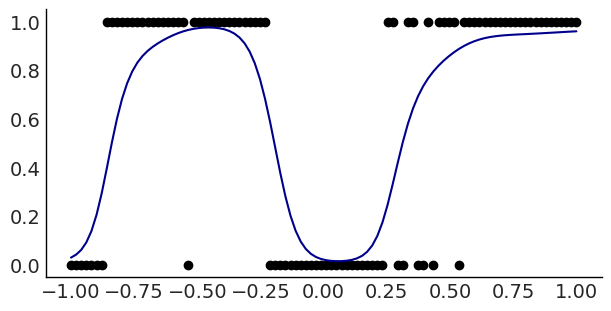

<IPython.core.display.Javascript object>

In [8]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(x, y, color="black")
plt.plot(x, rate, color="darkblue")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

In [9]:
dat = {"N": n, "x": x.flatten(), "y": y.flatten(), "alpha": alpha, "rho": rho}

<IPython.core.display.Javascript object>

In [10]:
sm = stan.StanModel(file="./_models/generalized_gpr.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d5bff401a9002f8e3e646a97d8fa76ec NOW.


<IPython.core.display.Javascript object>

In [11]:
fit = sm.sampling(data=dat, chains=4)

<IPython.core.display.Javascript object>

In [12]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_d5bff401a9002f8e3e646a97d8fa76ec.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f_tilde[1]    -1.03  7.4e-3    0.5  -2.06  -1.37  -1.01  -0.69   -0.1   4563    1.0
f_tilde[2]     1.03    0.01   0.79  -0.51   0.51   1.02   1.55   2.62   4213    1.0
f_tilde[3]     1.14    0.01   0.87  -0.57   0.56   1.12   1.73   2.86   5635    1.0
f_tilde[4]     0.69    0.01   0.87  -0.97    0.1   0.68   1.29   2.36   6828    1.0
f_tilde[5]     0.38    0.01   0.91   -1.4  -0.23   0.37   0.97   2.18   5172    1.0
f_tilde[6]      0.2    0.01   0.95  -1.64  -0.41   0.19   0.84   2.06   7434    1.0
f_tilde[7]     0.27    0.01   0.92  -1.53  -0.36   0.27    0.9   2.02   7862    1.0
f_tilde[8]     0.25    0.01   0.99  -1.72  -0.43   0.26   0.92   2.14   7640    1.0
f_tilde[9]     

<IPython.core.display.Javascript object>

In [13]:
extr = fit.extract()
f_tildes = extr["f_tilde"]

<IPython.core.display.Javascript object>

In [14]:
m = len(f_tildes)
p_fs = [None] * m
for i, p_f_tilde in enumerate(f_tildes):
    p_cov = alpha ** 2 * pm.gp.cov.ExpQuad(1, rho)
    p_K = p_cov(x).eval()
    p_L_K = sp.linalg.cholesky(p_K + np.eye(n) * 0.00001, lower=True)
    p_f = p_L_K @ p_f_tilde
    p_fs[i] = p_f
    if i == m - 1:
        break
p_fs = np.vstack(p_fs)

<IPython.core.display.Javascript object>

In [24]:
fquantiles = sp.special.expit(np.quantile(p_fs, q=[0.05, 0.95], axis=0))
fmean = sp.special.expit(np.mean(p_fs, axis=0))

<IPython.core.display.Javascript object>

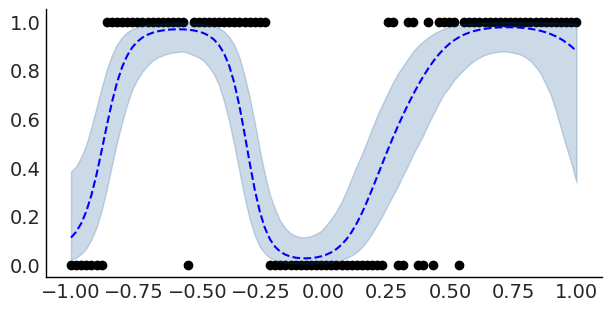

<IPython.core.display.Javascript object>

In [25]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(x, y, color="black")
plt.plot(x, fmean, color="blue", linestyle="dashed")
ax.fill_between(
    x.flatten(),
    fquantiles[1, :],
    fquantiles[0, :],
    color="#004787",
    alpha=0.2,
    label="Posterior interval",
)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()

In [17]:
np.random.choice(42)

n_new = 5
idxs_new = np.random.choice(n, n_new, replace=False)
x_new = x[idxs_new]
y_new = y[idxs_new]

<IPython.core.display.Javascript object>

In [18]:
dat_new = {
    "N": n,
    "x": x.flatten(),
    "y": y.flatten(),
    "alpha": alpha,
    "rho": rho,
    "N_new": n_new,
    "x_new": x_new.flatten(),
}

<IPython.core.display.Javascript object>

In [19]:
sm = stan.StanModel(file="./_models/generalized_gpr_predict.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7bbdc0ddcb8e57f05ee14c274b1ada1c NOW.


<IPython.core.display.Javascript object>

In [20]:
pred_fit = sm.sampling(data=dat_new, chains=2)

<IPython.core.display.Javascript object>

In [21]:
extr = pred_fit.extract()
y_new_hat = extr["y_new"]

<IPython.core.display.Javascript object>

In [22]:
y_new_hat_mean = np.mean(y_new_hat, axis=0)

<IPython.core.display.Javascript object>

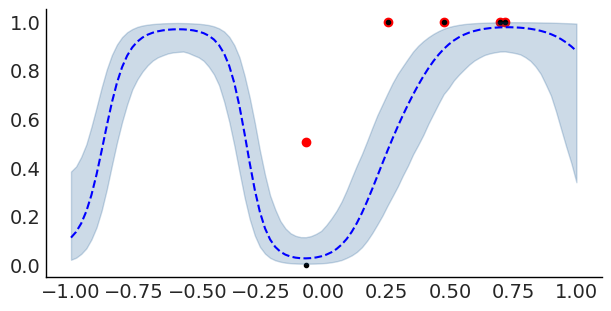

<IPython.core.display.Javascript object>

In [23]:
fig, ax = plt.subplots(figsize=(6, 3))
plt.scatter(x_new, y_new_hat_mean, color="red")
plt.scatter(x_new, y_new, color="black", marker=".")
plt.plot(x, fmean, color="blue", linestyle="dashed")
ax.fill_between(
    x.flatten(),
    fquantiles[1, :],
    fquantiles[0, :],
    color="#004787",
    alpha=0.2,
    label="Posterior interval",
)


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.show()


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)


%matplotlib inline

<IPython.core.display.Javascript object>

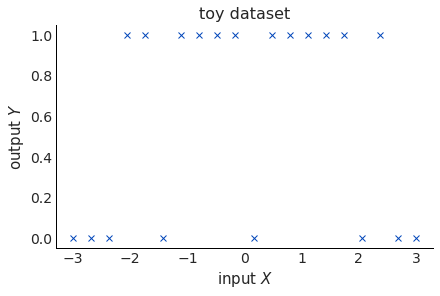

<IPython.core.display.Javascript object>

In [46]:
rng = np.random.RandomState(14)

X = np.linspace(-3, 3, 20)
Y = rng.binomial(n=1, p=sp.special.expit(np.sin(X) ** 2))

plt.figure()
plt.plot(X, Y, "x")
plt.xlabel("input $X$")
plt.ylabel("output $Y$")
plt.title("toy dataset")
plt.show()

data = (X[:, None], Y[:, None])

In [47]:
kernel = gpflow.kernels.Matern32()
likelihood = gpflow.likelihoods.Bernoulli()
model = gpflow.models.GPMC(data, kernel, likelihood)

<IPython.core.display.Javascript object>

In [48]:
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(20, 1)",float64,[[0....


<IPython.core.display.Javascript object>

In [49]:
num_burnin_steps = ci_niter(60)
num_samples = ci_niter(100)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn,
    num_leapfrog_steps=10,
    step_size=0.01,
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)

<IPython.core.display.Javascript object>

In [50]:
@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, _ = run_chain_fn()

<IPython.core.display.Javascript object>

In [51]:
parameter_samples = hmc_helper.convert_to_constrained_values(samples)
param_to_name = {
    param: name for name, param in gpflow.utilities.parameter_dict(model).items()
}

<IPython.core.display.Javascript object>

In [57]:
Xtest = np.linspace(-1, 1, 100)[:, None]
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(Xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

<IPython.core.display.Javascript object>

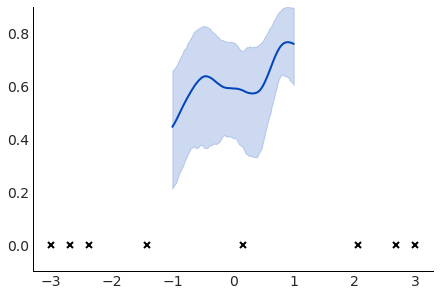

<IPython.core.display.Javascript object>

In [58]:
rate_samples = sp.special.expit(f_samples[:, :, 0])

(line,) = plt.plot(Xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(rate_samples, 5, axis=0),
    np.percentile(rate_samples, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, Y, "kx", mew=2)
_ = plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))